In [2]:
import fitz
import os
import numpy as np
import json
import re
from openai import OpenAI
import torch
from sentence_transformers import SentenceTransformer, SimilarityFunction
from tqdm import tqdm
import os
import numpy as np
from rank_bm25 import BM25Okapi
import fitz
from openai import OpenAI
import re
import json
import time
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict
import re
from PIL import Image

/home/patrick/rag_from_scratch/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the pre-trained model
embedder = SentenceTransformer("all-MiniLM-L6-v2") # Fazer o embedding usando esse

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY")
)

In [4]:
def extract_text_from_pdf(pdf_path):
    """
    Extract text content from a PDF file.
    
    Args:
        pdf_path (str): Path to the PDF file
        
    Returns:
        str: Extracted text content
    """
    print(f"Extracting text from {pdf_path}...")  # Print the path of the PDF being processed
    pdf_document = fitz.open(pdf_path)  # Open the PDF file using PyMuPDF
    text = ""  # Initialize an empty string to store the extracted text
    
    # Iterate through each page in the PDF
    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]  # Get the page object
        text += page.get_text()  # Extract text from the page and append to the text string
    
    return text  # Return the extracted text content

In [5]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    Split text into overlapping chunks.
    
    Args:
        text (str): Input text to chunk
        chunk_size (int): Size of each chunk in characters
        overlap (int): Overlap between chunks in characters
        
    Returns:
        List[Dict]: List of chunks with metadata
    """
    chunks = []  # Initialize an empty list to store the chunks
    
    # Iterate over the text with a step size of (chunk_size - overlap)
    for i in range(0, len(text), chunk_size - overlap):
        # Extract a chunk of text from the current position
        chunk_text = text[i:i + chunk_size]
        
        # Ensure we don't add empty chunks
        if chunk_text:
            # Append the chunk with its metadata to the list
            chunks.append({
                "text": chunk_text,  # The chunk of text
                "index": len(chunks),  # The index of the chunk
                "start_pos": i,  # The starting position of the chunk in the original text
                "end_pos": i + len(chunk_text)  # The ending position of the chunk in the original text
            })
    
    # Print the number of chunks created
    print(f"Created {len(chunks)} text chunks")
    
    return chunks  # Return the list of chunks

In [6]:
def create_embeddings(text):
    """
    Create embeddings for the given text.
    
    Args:
        texts (str or List[str]): Input text(s)
        model (str): Embedding model name
        
    Returns:
        List[List[float]]: Embedding vector(s)
    """
    # Create embeddings for the current batch
    response = embedder.encode(text)
    return response  # Return the embeddings
        

In [13]:

def extract_concepts(text):
    """
    Extract key concepts from text using OpenAI's API.
    
    Args:
        text (str): Text to extract concepts from
        
    Returns:
        List[str]: List of concepts
    """
    # System message to instruct the model on what to do
    system_message = """Extract key concepts and entities from the provided text.
Return ONLY a list of 5-10 key terms, entities, or concepts that are most important in this text.
Format your response as a JSON array of strings."""

    # Make a request to the OpenAI API
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"Extract key concepts from:\n\n{text[:3000]}"}  # Limit for API
        ],
        temperature=0.0,
        response_format={"type": "json_object"}
    )
    
    try:
        # Parse concepts from the response
        concepts_json = json.loads(response.choices[0].message.content)
        concepts = concepts_json.get("concepts", [])
        if not concepts and "concepts" not in concepts_json:
            # Try to get any array in the response
            for key, value in concepts_json.items():
                if isinstance(value, list):
                    concepts = value
                    break
        return concepts
    except (json.JSONDecodeError, AttributeError):
        # Fallback if JSON parsing fails
        content = response.choices[0].message.content
        # Try to extract anything that looks like a list
        matches = re.findall(r'\[(.*?)\]', content, re.DOTALL)
        if matches:
            items = re.findall(r'"([^"]*)"', matches[0])
            return items
        return []

In [14]:
def build_knowledge_graph(chunks):
    """
    Build a knowledge graph from text chunks.
    
    Args:
        chunks (List[Dict]): List of text chunks with metadata
        
    Returns:
        Tuple[nx.Graph, List[np.ndarray]]: The knowledge graph and chunk embeddings
    """
    print("Building knowledge graph...")
    
    # Create a graph
    graph = nx.Graph()
    
    # Extract chunk texts
    texts = [chunk["text"] for chunk in chunks]
    
    # Create embeddings for all chunks
    print("Creating embeddings for chunks...")
    embeddings = create_embeddings(texts)
    
    # Add nodes to the graph
    print("Adding nodes to the graph...")
    for i, chunk in enumerate(chunks):
        # Extract concepts from the chunk
        print(f"Extracting concepts for chunk {i+1}/{len(chunks)}...")
        concepts = extract_concepts(chunk["text"])
        
        # Add node with attributes
        graph.add_node(i, 
                      text=chunk["text"], 
                      concepts=concepts,
                      embedding=embeddings[i])
    
    # Connect nodes based on shared concepts
    print("Creating edges between nodes...")
    for i in range(len(chunks)):
        node_concepts = set(graph.nodes[i]["concepts"])
        
        for j in range(i + 1, len(chunks)):
            # Calculate concept overlap
            other_concepts = set(graph.nodes[j]["concepts"])
            shared_concepts = node_concepts.intersection(other_concepts)
            
            # If they share concepts, add an edge
            if shared_concepts:
                # Calculate semantic similarity using embeddings
                similarity = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                
                # Calculate edge weight based on concept overlap and semantic similarity
                concept_score = len(shared_concepts) / min(len(node_concepts), len(other_concepts))
                edge_weight = 0.7 * similarity + 0.3 * concept_score
                
                # Only add edges with significant relationship
                if edge_weight > 0.6:
                    graph.add_edge(i, j, 
                                  weight=edge_weight,
                                  similarity=similarity,
                                  shared_concepts=list(shared_concepts))
    
    print(f"Knowledge graph built with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")
    return graph, embeddings

In [15]:
def traverse_graph(query, graph, embeddings, top_k=5, max_depth=3):
    """
    Traverse the knowledge graph to find relevant information for the query.
    
    Args:
        query (str): The user's question
        graph (nx.Graph): The knowledge graph
        embeddings (List): List of node embeddings
        top_k (int): Number of initial nodes to consider
        max_depth (int): Maximum traversal depth
        
    Returns:
        List[Dict]: Relevant information from graph traversal
    """
    print(f"Traversing graph for query: {query}")
    
    # Get query embedding
    query_embedding = create_embeddings(query)
    
    # Calculate similarity between query and all nodes
    similarities = []
    for i, node_embedding in enumerate(embeddings):
        similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        similarities.append((i, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k most similar nodes as starting points
    starting_nodes = [node for node, _ in similarities[:top_k]]
    print(f"Starting traversal from {len(starting_nodes)} nodes")
    
    # Initialize traversal
    visited = set()  # Set to keep track of visited nodes
    traversal_path = []  # List to store the traversal path
    results = []  # List to store the results
    
    # Use a priority queue for traversal
    queue = []
    for node in starting_nodes:
        heapq.heappush(queue, (-similarities[node][1], node))  # Negative for max-heap
    
    # Traverse the graph using a modified breadth-first search with priority
    while queue and len(results) < (top_k * 3):  # Limit results to top_k * 3
        _, node = heapq.heappop(queue)
        
        if node in visited:
            continue
        
        # Mark as visited
        visited.add(node)
        traversal_path.append(node)
        
        # Add current node's text to results
        results.append({
            "text": graph.nodes[node]["text"],
            "concepts": graph.nodes[node]["concepts"],
            "node_id": node
        })
        
        # Explore neighbors if we haven't reached max depth
        if len(traversal_path) < max_depth:
            neighbors = [(neighbor, graph[node][neighbor]["weight"]) 
                        for neighbor in graph.neighbors(node)
                        if neighbor not in visited]
            
            # Add neighbors to queue based on edge weight
            for neighbor, weight in sorted(neighbors, key=lambda x: x[1], reverse=True):
                heapq.heappush(queue, (-weight, neighbor))
    
    print(f"Graph traversal found {len(results)} relevant chunks")
    return results, traversal_path

In [16]:
def generate_response(query, context_chunks):
    """
    Generate a response using the retrieved context.
    
    Args:
        query (str): The user's question
        context_chunks (List[Dict]): Relevant chunks from graph traversal
        
    Returns:
        str: Generated response
    """
    # Extract text from each chunk in the context
    context_texts = [chunk["text"] for chunk in context_chunks]
    
    # Combine the extracted texts into a single context string, separated by "---"
    combined_context = "\n\n---\n\n".join(context_texts)
    
    # Define the maximum allowed length for the context (OpenAI limit)
    max_context = 14000
    
    # Truncate the combined context if it exceeds the maximum length
    if len(combined_context) > max_context:
        combined_context = combined_context[:max_context] + "... [truncated]"
    
    # Define the system message to guide the AI assistant
    system_message = """You are a helpful AI assistant. Answer the user's question based on the provided context.
If the information is not in the context, say so. Refer to specific parts of the context in your answer when possible."""

    # Generate the response using the OpenAI API
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",  # Specify the model to use
        messages=[
            {"role": "system", "content": system_message},  # System message to guide the assistant
            {"role": "user", "content": f"Context:\n{combined_context}\n\nQuestion: {query}"}  # User message with context and query
        ],
        temperature=0.2  # Set the temperature for response generation
    )
    
    # Return the generated response content
    return response.choices[0].message.content

In [17]:
def visualize_graph_traversal(graph, traversal_path):
    """
    Visualize the knowledge graph and the traversal path.
    
    Args:
        graph (nx.Graph): The knowledge graph
        traversal_path (List): List of nodes in traversal order
    """
    plt.figure(figsize=(12, 10))  # Set the figure size
    
    # Define node colors, default to light blue
    node_color = ['lightblue'] * graph.number_of_nodes()
    
    # Highlight traversal path nodes in light green
    for node in traversal_path:
        node_color[node] = 'lightgreen'
    
    # Highlight start node in green and end node in red
    if traversal_path:
        node_color[traversal_path[0]] = 'green'
        node_color[traversal_path[-1]] = 'red'
    
    # Create positions for all nodes using spring layout
    pos = nx.spring_layout(graph, k=0.5, iterations=50, seed=42)
    
    # Draw the graph nodes
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500, alpha=0.8)
    
    # Draw edges with width proportional to weight
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1.0)
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=weight*2, alpha=0.6)
    
    # Draw traversal path with red dashed lines
    traversal_edges = [(traversal_path[i], traversal_path[i+1]) 
                      for i in range(len(traversal_path)-1)]
    
    nx.draw_networkx_edges(graph, pos, edgelist=traversal_edges, 
                          width=3, alpha=0.8, edge_color='red', 
                          style='dashed', arrows=True)
    
    # Add labels with the first concept for each node
    labels = {}
    for node in graph.nodes():
        concepts = graph.nodes[node]['concepts']
        label = concepts[0] if concepts else f"Node {node}"
        labels[node] = f"{node}: {label}"
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)
    
    plt.title("Knowledge Graph with Traversal Path")  # Set the plot title
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot

In [18]:
def graph_rag_pipeline(pdf_path, query, chunk_size=1000, chunk_overlap=200, top_k=3):
    """
    Complete Graph RAG pipeline from document to answer.
    
    Args:
        pdf_path (str): Path to the PDF document
        query (str): The user's question
        chunk_size (int): Size of text chunks
        chunk_overlap (int): Overlap between chunks
        top_k (int): Number of top nodes to consider for traversal
        
    Returns:
        Dict: Results including answer and graph visualization data
    """
    # Extract text from the PDF document
    text = extract_text_from_pdf(pdf_path)
    
    # Split the extracted text into overlapping chunks
    chunks = chunk_text(text, chunk_size, chunk_overlap)
    
    # Build a knowledge graph from the text chunks
    graph, embeddings = build_knowledge_graph(chunks)
    
    # Traverse the knowledge graph to find relevant information for the query
    relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings, top_k)
    
    # Generate a response based on the query and the relevant chunks
    response = generate_response(query, relevant_chunks)
    
    # Visualize the graph traversal path
    visualize_graph_traversal(graph, traversal_path)
    
    # Return the query, response, relevant chunks, traversal path, and the graph
    return {
        "query": query,
        "response": response,
        "relevant_chunks": relevant_chunks,
        "traversal_path": traversal_path,
        "graph": graph
    }

In [24]:
pdf_path = "AI_Information.pdf"  # Path to the PDF document
query = "What is AI?"  # User's question
chunk_size = 2000  # Size of text chunks
chunk_overlap = 200  # Overlap between chunks
top_k = 3  # Number of top nodes to consider for traversal


Extracting text from AI_Information.pdf...
Created 19 text chunks
Building knowledge graph...
Creating embeddings for chunks...
Adding nodes to the graph...
Extracting concepts for chunk 1/19...
Extracting concepts for chunk 2/19...
Extracting concepts for chunk 3/19...
Extracting concepts for chunk 4/19...
Extracting concepts for chunk 5/19...
Extracting concepts for chunk 6/19...
Extracting concepts for chunk 7/19...
Extracting concepts for chunk 8/19...
Extracting concepts for chunk 9/19...
Extracting concepts for chunk 10/19...
Extracting concepts for chunk 11/19...
Extracting concepts for chunk 12/19...
Extracting concepts for chunk 13/19...
Extracting concepts for chunk 14/19...
Extracting concepts for chunk 15/19...
Extracting concepts for chunk 16/19...
Extracting concepts for chunk 17/19...
Extracting concepts for chunk 18/19...
Extracting concepts for chunk 19/19...
Creating edges between nodes...
Knowledge graph built with 19 nodes and 0 edges
Traversing graph for query: Wha

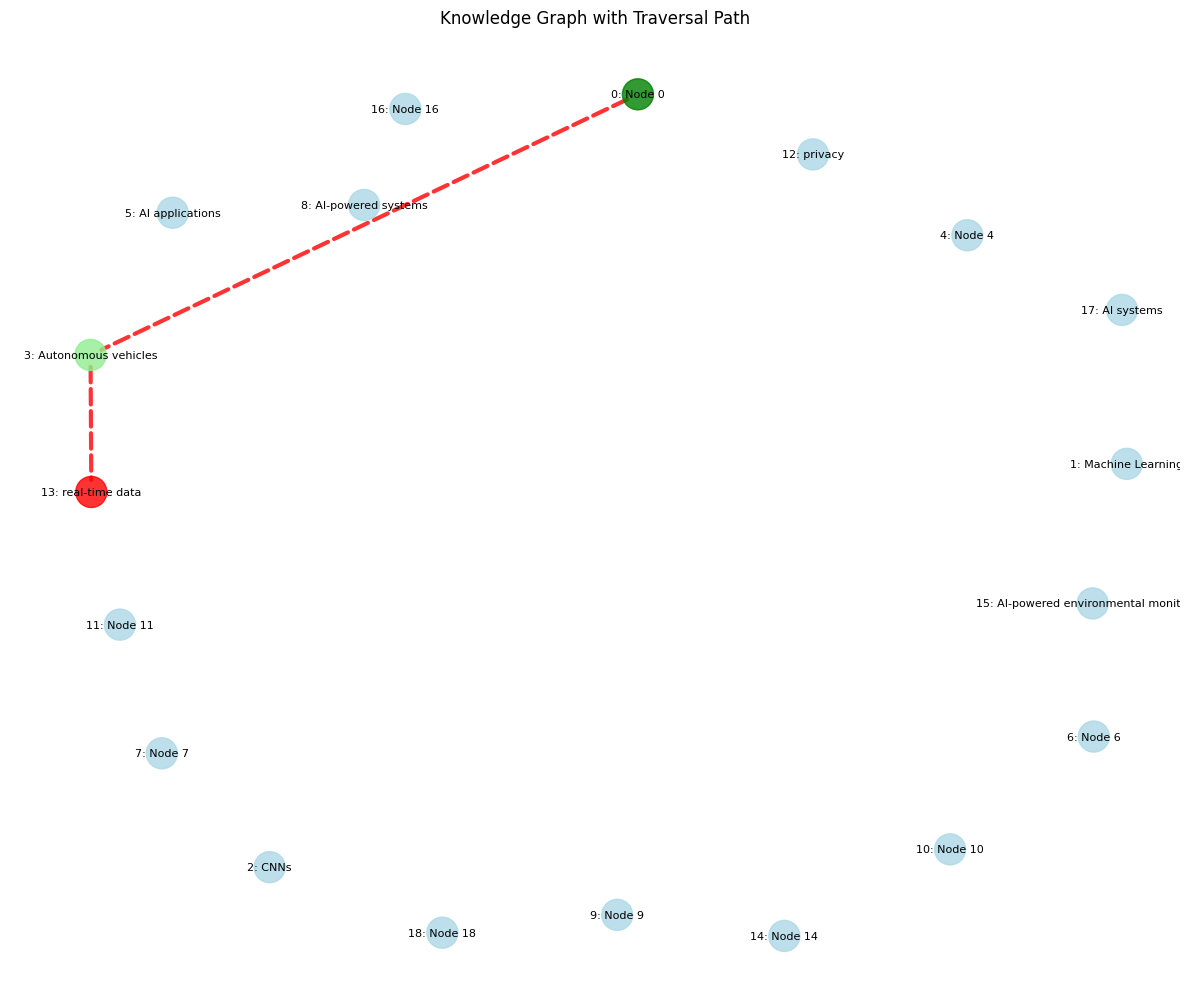

{'query': 'What is AI?',
 'response': 'AI, or artificial intelligence, refers to the ability of a digital computer or computer-controlled robot to perform tasks commonly associated with intelligent beings, such as reasoning, discovering meaning, generalizing, or learning from past experience. It encompasses various technologies and techniques, including machine learning, deep learning, and neural networks, and is increasingly prevalent in everyday life, impacting industries such as autonomous vehicles, retail, manufacturing, education, entertainment, cybersecurity, and more. Additionally, AI research is focused on addressing ethical and societal implications, advancing deep learning, developing explainable AI, exploring the intersection of AI and neuroscience, ensuring AI safety and security, and promoting human-centered AI.',
 'relevant_chunks': [{'text': 'Understanding Artificial Intelligence \nChapter 1: Introduction to Artificial Intelligence \nArtificial intelligence (AI) refers t

In [23]:
graph_rag_pipeline(pdf_path=pdf_path, query=query, chunk_size=chunk_size, chunk_overlap=chunk_overlap, top_k=top_k)

Extracting text from AI_Information.pdf...
Created 42 text chunks
Building knowledge graph...
Creating embeddings for chunks...
Adding nodes to the graph...
Extracting concepts for chunk 1/42...
Extracting concepts for chunk 2/42...
Extracting concepts for chunk 3/42...
Extracting concepts for chunk 4/42...
Extracting concepts for chunk 5/42...
Extracting concepts for chunk 6/42...
Extracting concepts for chunk 7/42...
Extracting concepts for chunk 8/42...
Extracting concepts for chunk 9/42...
Extracting concepts for chunk 10/42...
Extracting concepts for chunk 11/42...
Extracting concepts for chunk 12/42...
Extracting concepts for chunk 13/42...
Extracting concepts for chunk 14/42...
Extracting concepts for chunk 15/42...
Extracting concepts for chunk 16/42...
Extracting concepts for chunk 17/42...
Extracting concepts for chunk 18/42...
Extracting concepts for chunk 19/42...
Extracting concepts for chunk 20/42...
Extracting concepts for chunk 21/42...
Extracting concepts for chunk 22/

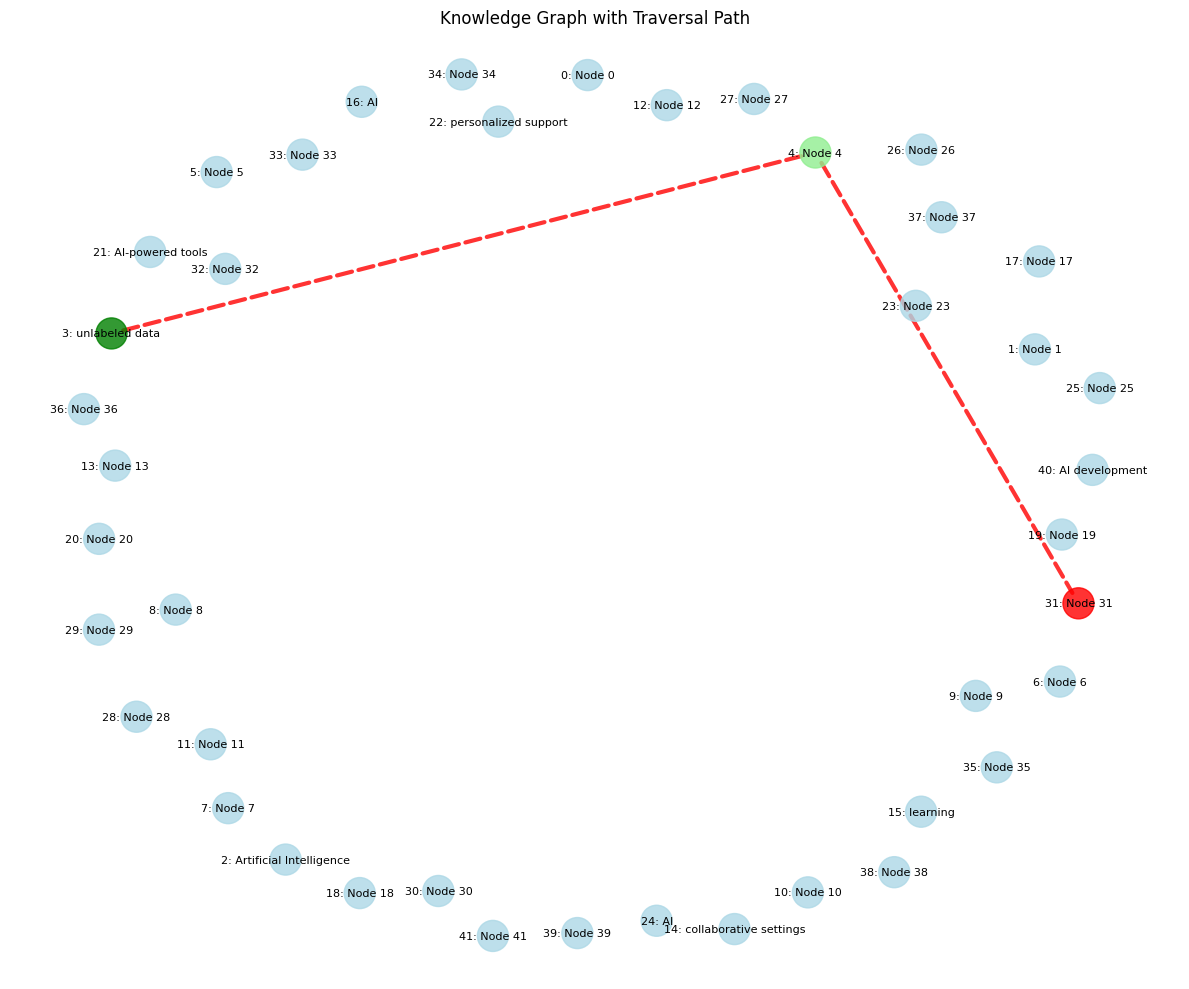

{'query': 'How do transformers handle sequential data compared to RNNs?',
 'response': 'Transformers and RNNs handle sequential data differently. RNNs are designed to process sequential data by using feedback connections that allow information to persist over time, making them suitable for tasks like language translation, speech recognition, and sentiment analysis. On the other hand, transformers use a mechanism called self-attention to handle sequential data, allowing them to capture dependencies between different words in a sequence without relying on sequential processing, which can make them more efficient for parallel computation. This makes transformers particularly effective for tasks such as language translation, text generation, and other natural language processing tasks.',
 'relevant_chunks': [{'text': 'trained on unlabeled data, where the algorithm must \ndiscover patterns and structures in the data without explicit guidance. Common techniques \ninclude clustering (grouping

In [26]:
pdf_path = "AI_Information.pdf"  # Path to the PDF document
query = "How do transformers handle sequential data compared to RNNs?"  # User's question
chunk_size = 1000  # Size of text chunks
chunk_overlap = 200  # Overlap between chunks
top_k = 3  # Number of top nodes to consider for traversal
graph_rag_pipeline(pdf_path=pdf_path, query=query, chunk_size=chunk_size, chunk_overlap=chunk_overlap, top_k=top_k)